In [1]:
import sqlite3

import pandas as pd

# Подключение к базе данных (файл будет создан автоматически)
conn = sqlite3.connect('bmws.db')
cursor = conn.cursor()

# Создаем таблицу
cursor.execute('''
    CREATE TABLE IF NOT EXISTS bmw (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
    model TEXT,
    year INTEGER,
    price INTEGER,
    mileage INTEGER,
    fuel_type TEXT
    )
''')
df = pd.read_csv('../Hw5/bmw.csv')  # Уточните имя файла
df.to_sql('bmw', conn, if_exists='replace', index=False)

# Проверка первых 5 записей
query = "SELECT * FROM bmw LIMIT 10;"
print(pd.read_sql_query(query, conn))
print('\nDataFrame Info:')
print(df.info())

# Quick summary statistics of numeric columns
print('\nSummary statistics:')
print(df.describe())
# Сохраните изменения и закройте соединение
conn.commit()
conn.close()


       model  year  price transmission  mileage fuelType  tax   mpg  \
0   5 Series  2014  11200    Automatic    67068   Diesel  125  57.6   
1   6 Series  2018  27000    Automatic    14827   Petrol  145  42.8   
2   5 Series  2016  16000    Automatic    62794   Diesel  160  51.4   
3   1 Series  2017  12750    Automatic    26676   Diesel  145  72.4   
4   7 Series  2014  14500    Automatic    39554   Diesel  160  50.4   
5   5 Series  2016  14900    Automatic    35309   Diesel  125  60.1   
6   5 Series  2017  16000    Automatic    38538   Diesel  125  60.1   
7   2 Series  2018  16250       Manual    10401   Petrol  145  52.3   
8   4 Series  2017  14250       Manual    42668   Diesel   30  62.8   
9   5 Series  2016  14250    Automatic    36099   Diesel   20  68.9   

   engineSize  
0         2.0  
1         2.0  
2         3.0  
3         1.5  
4         3.0  
5         2.0  
6         2.0  
7         1.5  
8         2.0  
9         2.0  

DataFrame Info:
<class 'pandas.core.frame


Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
R-squared score of the price prediction model: 0.642

Model Coefficients:
      Feature   Coefficient
0        year   2004.330452
1     mileage     -0.131167
2         mpg     20.110281
3  engineSize  10264.865326


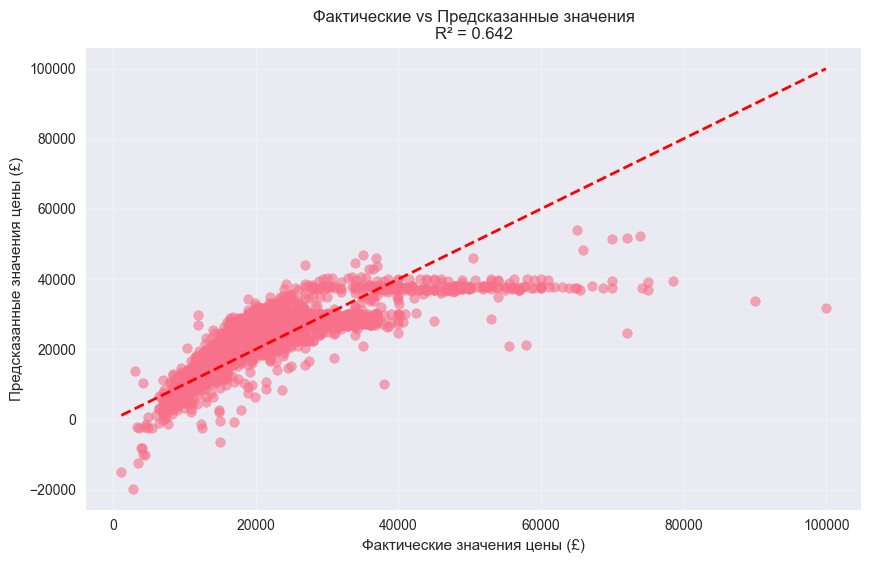

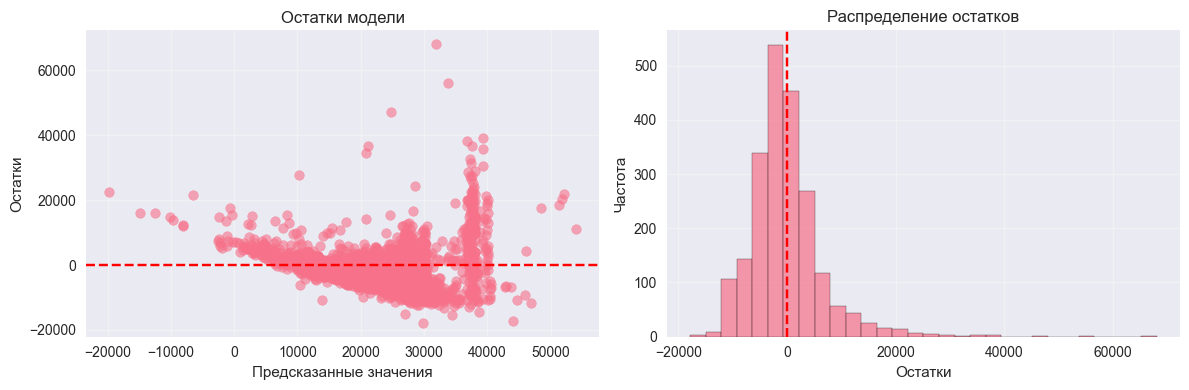

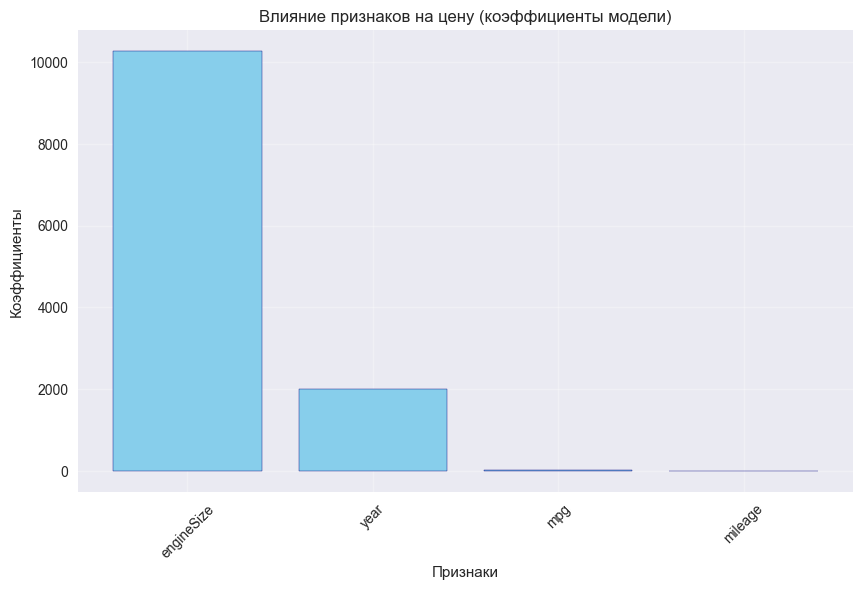

In [7]:
from Hw5.data_preprocessing import preprocess_car_data
from Hw5.data import load_data_from_db
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

features = ['year', 'mileage', 'mpg', 'engineSize']
target = 'price'

# Split the data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the prediction using the R-squared metric
r2 = r2_score(y_test, y_pred)
print(f'R-squared score of the price prediction model: {r2:.3f}')

# A brief look at the coefficients of the model for interpretability
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print('\nModel Coefficients:')
print(coefficients)

# Настройка стиля для визуализаций
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Фактические vs Предсказанные значения с линией идеального предсказания
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения цены (£)')
plt.ylabel('Предсказанные значения цены (£)')
plt.title(f'Фактические vs Предсказанные значения\nR² = {r2:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Анализ остатков модели
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))

# График остатков
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки модели')
plt.grid(True, alpha=0.3)

# Распределение остатков
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Важность признаков (коэффициенты модели)
plt.figure(figsize=(10, 6))
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'],
        color='skyblue', edgecolor='navy')
plt.xlabel('Признаки')
plt.ylabel('Коэффициенты')
plt.title('Влияние признаков на цену (коэффициенты модели)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
Mean Squared Error (MSE): 54995948.781066775
R-squared (R2): 0.577935366503219


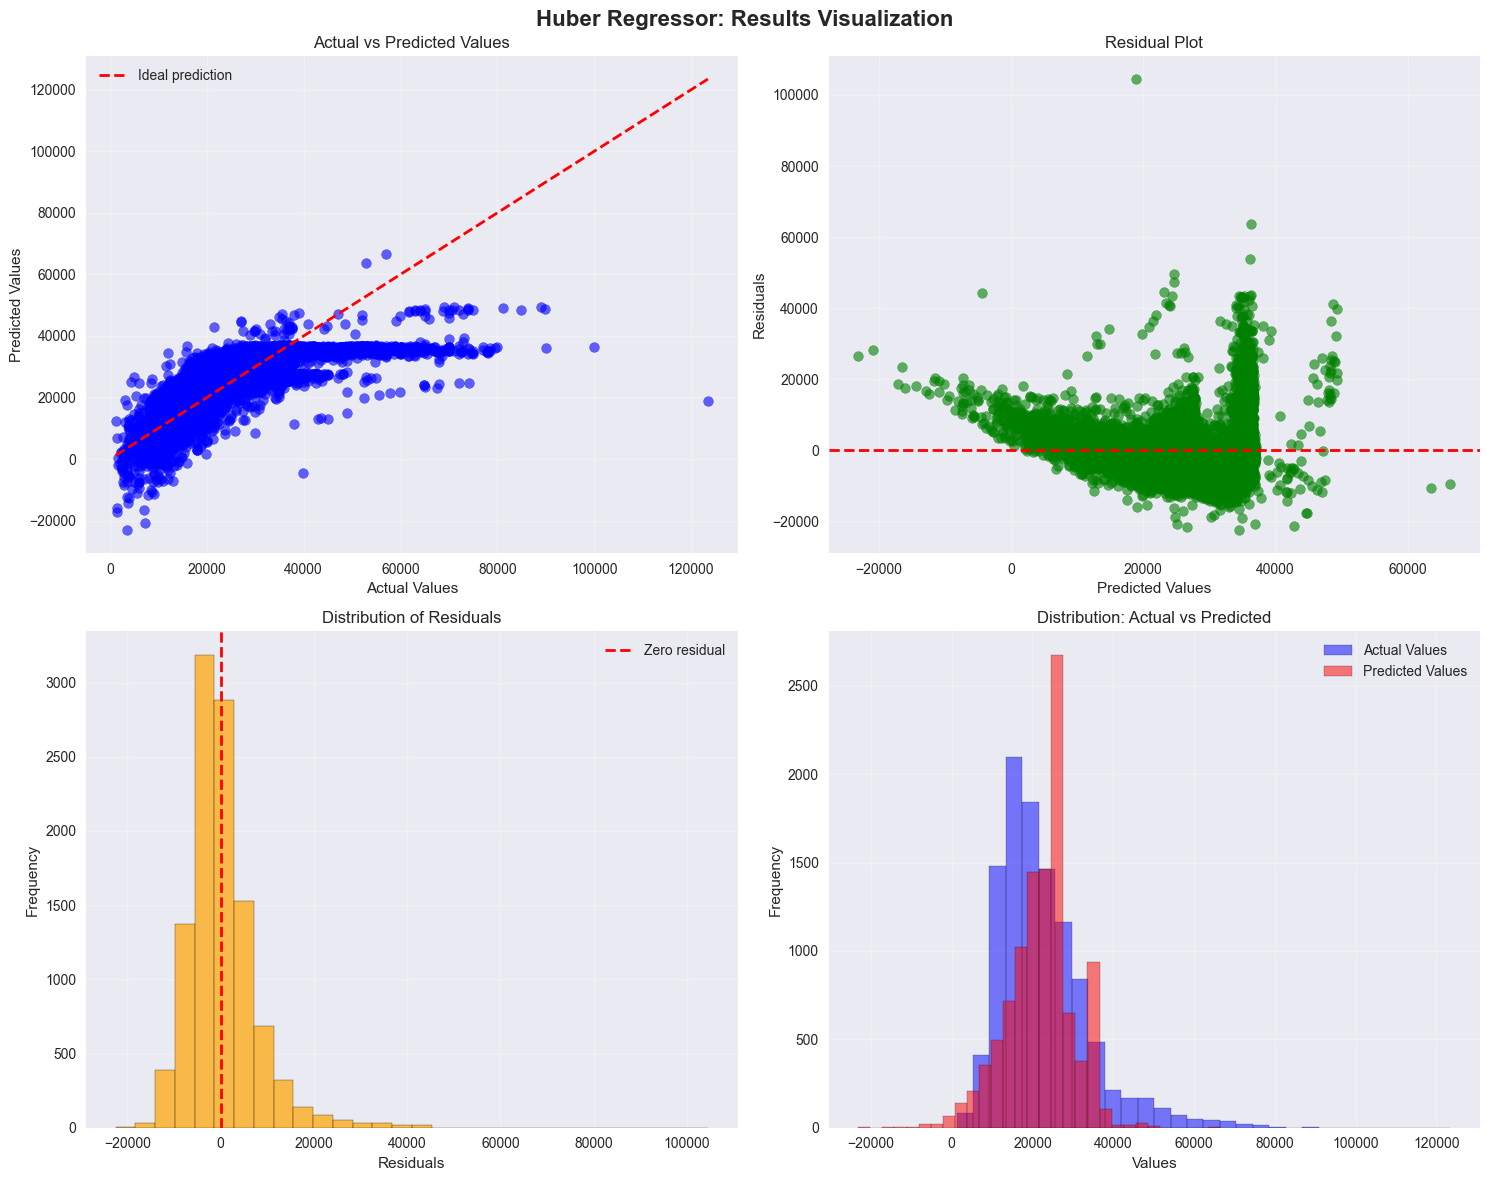

In [35]:
from Hw5.data_preprocessing import preprocess_car_data
from Hw5.data import load_data_from_db
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import HuberRegressor

df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

# Инициализируем и обучаем модель регрессора Губера
model = HuberRegressor(epsilon=2.5)  # Задаем параметр epsilon, который контролирует устойчивость к выбросам
model.fit(X, y)

# Сделаем предсказания
y_pred = model.predict(X)

# Вычислим метрики
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Выведем метрики
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# ВИЗУАЛИЗАЦИЯ
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Huber Regressor: Results Visualization', fontsize=16, fontweight='bold')

# График предсказаний vs фактические значения
axes[0, 0].scatter(y, y_pred, alpha=0.6, color='blue', s=50)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal prediction')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Actual vs Predicted Values')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# График остатков
residuals = y - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', s=50)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Распределение остатков
axes[1, 0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero residual')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Сравнение распределений фактических и предсказанных значений
axes[1, 1].hist(y, bins=30, alpha=0.5, label='Actual Values', color='blue', edgecolor='black')
axes[1, 1].hist(y_pred, bins=30, alpha=0.5, label='Predicted Values', color='red', edgecolor='black')
axes[1, 1].set_xlabel('Values')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution: Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [42]:
from Hw5.data_preprocessing import preprocess_car_data
from Hw5.data import load_data_from_db
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

# Инициализируем и обучаем модель регрессора дерева решений
model = DecisionTreeRegressor(max_depth=20)
model.fit(X, y)

# Сделаем предсказания
y_pred = model.predict(X)

# Вычислим метрики
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Выведем метрики
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Загрузка и предобработка данных
df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

# Обучение модели
model = DecisionTreeRegressor(max_depth=20)
model.fit(X, y)

# Предсказания
y_pred = model.predict(X)

# Метрики
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# ВИЗУАЛИЗАЦИЯ

# 1. График предсказаний vs фактические значения
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=y, y=y_pred, mode='markers',
                          name='Предсказания',
                          marker=dict(color='blue', opacity=0.6)))
fig1.add_trace(go.Scatter(x=[y.min(), y.max()], y=[y.min(), y.max()],
                          mode='lines',
                          name='Идеальная линия',
                          line=dict(color='red', dash='dash')))
fig1.update_layout(
    title='Фактические vs Предсказанные значения',
    xaxis_title='Фактические значения',
    yaxis_title='Предсказанные значения',
    showlegend=True
)
fig1.show()

# 2. Остатки регрессии
residuals = y - y_pred
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=y_pred, y=residuals, mode='markers',
                          marker=dict(color='green', opacity=0.6)))
fig2.add_hline(y=0, line_dash="dash", line_color="red")
fig2.update_layout(
    title='Остатки регрессии',
    xaxis_title='Предсказанные значения',
    yaxis_title='Остатки',
    showlegend=False
)
fig2.show()

# 3. Гистограмма распределения ошибок
fig3 = px.histogram(x=residuals, nbins=50,
                    title='Распределение ошибок предсказания',
                    labels={'x': 'Ошибка', 'y': 'Частота'})
fig3.add_vline(x=0, line_dash="dash", line_color="red")
fig3.show()

# 4. Сравнение метрик
metrics_df = pd.DataFrame({
    'Метрика': ['MSE', 'R²'],
    'Значение': [mse, r2]
})

fig4 = px.bar(metrics_df, x='Метрика', y='Значение',
              title='Метрики качества модели',
              color='Метрика',
              text='Значение')
fig4.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig4.show()



Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
Mean Squared Error (MSE): 800258.4731991267
R-squared (R2): 0.9938584421820219

Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
Mean Squared Error (MSE): 800258.4731991267
R-squared (R2): 0.9938584421820219



Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
K-ближайшие соседи - Средняя абсолютная ошибка (MAE): 16.71
K-ближайшие соседи - Среднеквадратичная ошибка (MSE): 433.22
K-ближайшие соседи - Коэффициент детерминации (R²): 0.34


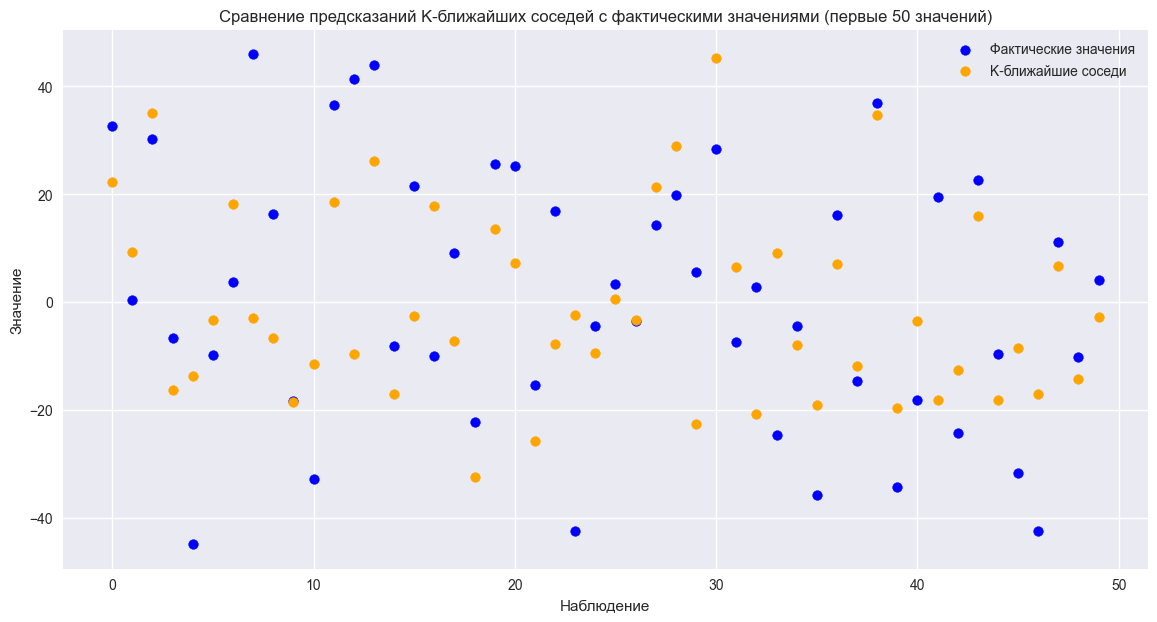

In [76]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from Hw5.data_preprocessing import preprocess_car_data
from Hw5.data import load_data_from_db
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

# Генерация искусственного датасета
X, y = make_regression(n_samples=1000, n_features=1, noise=20, random_state=42)

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создаем модель K-ближайших соседей
knn_regressor = KNeighborsRegressor(
    n_neighbors=13)  # для предсказания значения целевой переменной для нового наблюдения будет использоваться 5 ближайших соседей из обучающей выборки.

# Обучаем модель K-ближайших соседей
knn_regressor.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе
y_pred_knn = knn_regressor.predict(X_test)

# Вычисление метрик для K-ближайших соседей
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"K-ближайшие соседи - Средняя абсолютная ошибка (MAE): {mae_knn:.2f}")
print(f"K-ближайшие соседи - Среднеквадратичная ошибка (MSE): {mse_knn:.2f}")
print(f"K-ближайшие соседи - Коэффициент детерминации (R²): {r2_knn:.2f}")

# Визуализация предсказаний K-ближайших соседей и фактических значений (первые 50 значений)
plt.figure(figsize=(14, 7))

plt.scatter(range(50), y_test[:50], label='Фактические значения', color='blue')
plt.scatter(range(50), y_pred_knn[:50], label='K-ближайшие соседи', color='orange')

plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Сравнение предсказаний K-ближайших соседей с фактическими значениями (первые 50 значений)')
plt.legend()
plt.show()



Data types after conversion:
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object
R^2 score on test data: 0.86


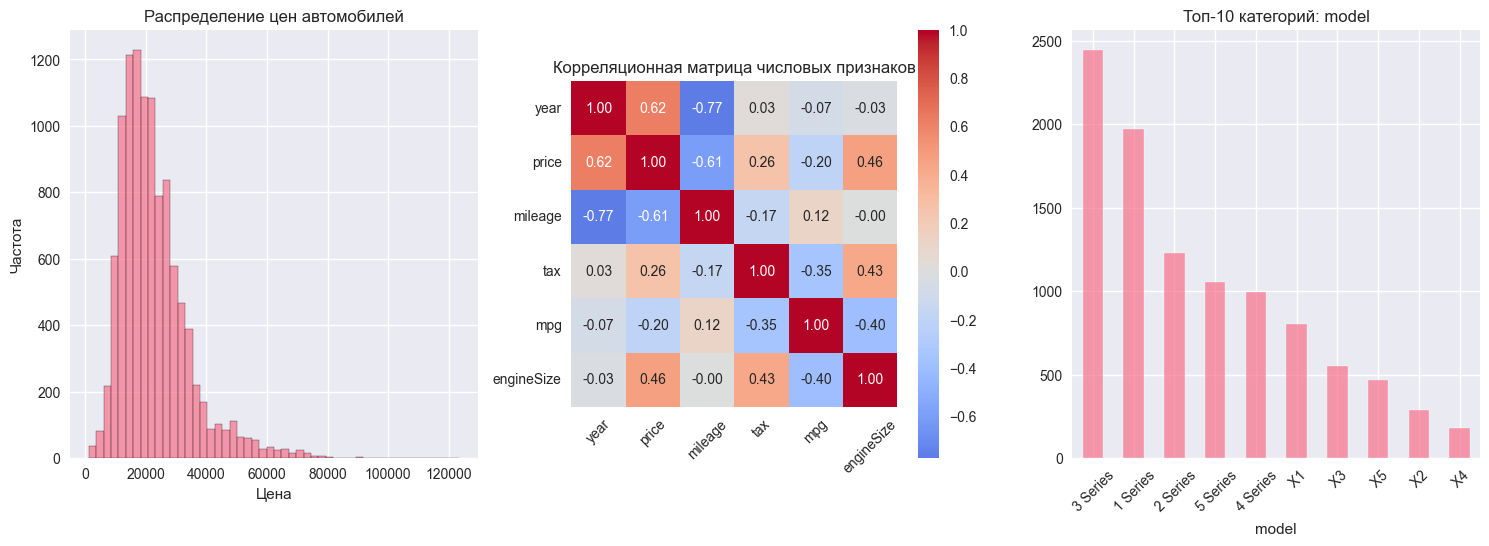

Text(0.5, 1.0, 'Распределение ошибок предсказания')

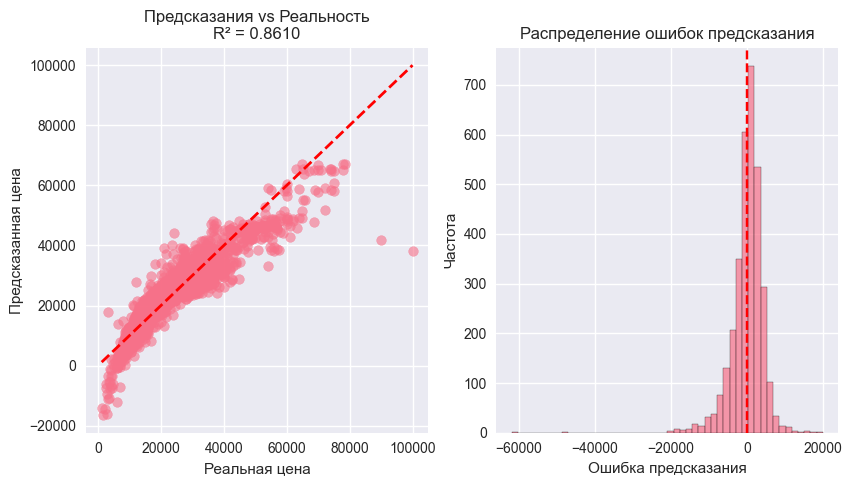

In [22]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from Hw5.data_preprocessing import preprocess_car_data
from Hw5.data import load_data_from_db
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

df = load_data_from_db('bmws.db')
df_preprocessed = preprocess_car_data(df)

# Разделение данных на признаки и целевую переменную
X = df_preprocessed.drop(columns=["price"])
y = df_preprocessed["price"]

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определим числовые и категориальные столбцы
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создадим преобразователи для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.99, random_state=42))
])

elastic_net_pipeline.fit(X_train, y_train)

# Предсказания
y_pred = elastic_net_pipeline.predict(X_test)

test_score = elastic_net_pipeline.score(X_test, y_test)
print(f"R^2 score on test data: {test_score:.2f}")

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Визуализация 1: Распределение целевой переменной (цены)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df_preprocessed['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')

# Визуализация 2: Корреляционная матриза для числовых признаков
plt.subplot(2, 3, 2)
numeric_cols = df_preprocessed.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_preprocessed[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True)
plt.title('Корреляционная матрица числовых признаков')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Визуализация 3: Статистика по категориальным признакам
categorical_cols = df_preprocessed.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    plt.subplot(2, 3, 3)
    top_categories = df_preprocessed[categorical_cols[0]].value_counts().head(10)
    top_categories.plot(kind='bar', alpha=0.7)
    plt.title(f'Топ-10 категорий: {categorical_cols[0]}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Визуализация 4: Сравнение предсказаний с реальными значениями
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title(f'Предсказания vs Реальность\nR² = {test_score:.4f}')

# Визуализация 5: Ошибки предсказания
plt.subplot(1, 3, 2)
errors = y_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания')